In [1]:
import numpy as np
import matplotlib.pyplot as plt # plot
import pandas as pd
from scipy.integrate import solve_ivp  # to solve ODE system
from scipy.integrate import simps # calculate the yield with Simpson rule
from numpy import trapz # calculate the yield with trapezoid rule
from SALib.sample.morris import sample as ee_sample # sensitivity analysis
from SALib.analyze.morris import analyze as ee_analyze # sensitivity analysis
from tqdm import tqdm
#from scipy.special import logsumexp # deal with NaN
import seaborn as sns # colourful plot

In [2]:
seed = 1234
method = "Radau"

In [3]:
tmax = 900 # 5000 for the numerical continuation, 900 for the time series
step = tmax*10
time_list = np.linspace(0, tmax, step)
num_of_points = 100

# Stage-structured Model Egg

## Parameter values

r=0.7
K=10
aL=0.18
hL=2
KBt=190
f=2
nE=1
aP=0.08
alpha=0.5 # 0<alpha<1
cL=1
qL=0.015
nL=0.01
mBt=1
mA=0.05
mP=0.5
RP=0
sig=2
bound=20 # economic threshold

In [4]:
r=0.7
K=10
aL=0.18
hL=2
KBt=190
f=2
nE=1
aP=0.06
alpha=0.5 # 0<alpha<1
cL=1
qL=0.01
nL=0.01
mBt=0.04
mA=0.1
mP=0.3
RP=0
sig=2
bound=20 # economic threshold

In [5]:
def ddf(t,sig_1,value_1,bound_1): #(t,sig,A,bound)
    val = 0.0
    if value_1>bound_1:
        t_transition=0.1
        half_life_time=1e5
        decay_constant = np.log(2)/half_life_time
        val = sig_1 * np.exp(-decay_constant * (t - t_transition))
    return val
inoculative_function = ddf

def ddf(t,sig_1,value_1,value_2,bound_1): #(t,sig,A,bound)
    val = 0.0
    x0 = value_2
    x1 = x0 + sig_1
    w = 0.05
    sigmat = 1.0 / (1.0 + np.exp(-(1 - t) / w))
    if value_1>bound_1:
        val = ( x0 + (x1 - x0)*(1 - sigmat) ) # https://kitchingroup.cheme.cmu.edu/blog/2013/02/27/Smooth-transitions-between-two-constants/
    return val
inoculative_function = ddf

In [6]:
def structured_parasitism_model(
    t,
    X,
    r=r,
    K=K,
    aL=aL,
    hL=hL,
    KBt=KBt,
    f=f,
    nE=nE,
    aP=aP,
    alpha=alpha,
    cL=cL,
    qL=qL,
    nL=nL,
    mBt=mBt,
    mA=mA,
    mP=mP,
    RP=RP,
    RP_function=inoculative_function,
    sig=sig,
    bound=bound,
):
    C,CBt,E,EBt,L,LBt,A,P = X
#    C: crop
#    CBt: genetically modified Bt crop
#    E: egg pest
#    EBt: egg pest in CBt
#    L: larvae pest in C
#    LBt: larvae pest in CBt
#    A: adult moth pest
#    P: parasitoid of egg (biocontrol agent)
    C_prime=r*C*(1-C/K)-aL*C*A/(1+hL*C)
    CBt_prime=r*CBt*(1-CBt/KBt)-aL*CBt*A/(1+hL*CBt)
    E_prime=(K/(K+KBt))*f*A-nE*E-aP*(E**alpha)*P
    EBt_prime=(KBt/(K+KBt))*f*A-nE*EBt-aP*(EBt**alpha)*P
    L_prime=cL*E*C*A/(1+hL*C)-qL*L**2-nL*L
    LBt_prime=cL*EBt*CBt*A/(1+hL*CBt)-qL*LBt**2-mBt*LBt-nL*LBt
    A_prime=nL*(L+LBt)-mA*A
    RP=RP_function(t,sig,A,bound)
    P_prime=aP*(E**alpha+EBt**alpha)*P-mP*P+RP
#    return C_prime,CBt_prime,E_prime,EBt_prime,L_prime,LBt_prime,A_prime,P_prime
    return np.nan_to_num(C_prime),np.nan_to_num(CBt_prime),np.nan_to_num(E_prime),np.nan_to_num(EBt_prime),np.nan_to_num(L_prime),np.nan_to_num(LBt_prime),np.nan_to_num(A_prime),np.nan_to_num(P_prime)

def structured_parasitism_ode_solver(
    y0,
    t_span,
    t_eval,
    r=r,
    K=K,
    aL=aL,
    hL=hL,
    KBt=KBt,
    f=f,
    nE=nE,
    aP=aP,
    alpha=alpha,
    cL=cL,
    qL=qL,
    nL=nL,
    mBt=mBt,
    mA=mA,
    mP=mP,
    RP=RP,
    RP_function=inoculative_function,
    sig=sig,
    bound=bound,
):
    solution_ODE_structured_parasitism = solve_ivp(
        fun=structured_parasitism_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r,K,aL,hL,KBt,f,nE,aP,alpha,cL,qL,nL,mBt,mA,mP),
        method=method,
    )
    return np.nan_to_num(solution_ODE_structured_parasitism)

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0

In [7]:
# Initial conditions
y0 = np.array([10, 150, 0, 0, 0, 0, 5, 0]) # C, CBt, E, EBt, L, LBt, A, P

solution_ODE_structured_parasitism = structured_parasitism_ode_solver(y0,(t0, tf + days_to_forecast),time_list,r=r,K=K,aL=aL,hL=hL,KBt=KBt,mBt=mBt,f=f,nE=nE,aP=aP,alpha=alpha,mP=mP,cL=cL,qL=qL,nL=nL,mA=mA)
t_computed_structured_parasitism, y_computed_structured_parasitism = solution_ODE_structured_parasitism.t, solution_ODE_structured_parasitism.y
C,CBt,E,EBt,L,LBt,A,P = y_computed_structured_parasitism

<ipython-input-6-855860f0a649>:35: RuntimeWarning: invalid value encountered in double_scalars
  E_prime=(K/(K+KBt))*f*A-nE*E-aP*(E**alpha)*P
<ipython-input-6-855860f0a649>:41: RuntimeWarning: invalid value encountered in double_scalars
  P_prime=aP*(E**alpha+EBt**alpha)*P-mP*P+RP
<ipython-input-6-855860f0a649>:36: RuntimeWarning: invalid value encountered in double_scalars
  EBt_prime=(KBt/(K+KBt))*f*A-nE*EBt-aP*(EBt**alpha)*P


In [8]:
print(C[-1], CBt[-1], E[-1], EBt[-1], L[-1], LBt[-1], A[-1], P[-1])

8.275806451342936 188.47870301347479 0.5106300460609668 18.36502716276496 16.340523746719946 101.34746072480868 11.768719997635584 15.539164928076865


In [9]:
# Area under the curve
print(trapz(C+CBt),simps(C+CBt))

1770250.400982232 1770250.5744063663


<ipython-input-10-d504fcc67bd0>:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


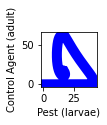

In [10]:
fig, ax = plt.subplots(figsize=(1, 1))

ax.plot(L, P, linestyle="-", linewidth=10, markersize=12,color="b")

plt.xlabel("Pest (larvae)")
plt.ylabel("Control Agent (adult)")
plt.rcParams.update({'font.size': 30})

plt.tight_layout()
plt.show()

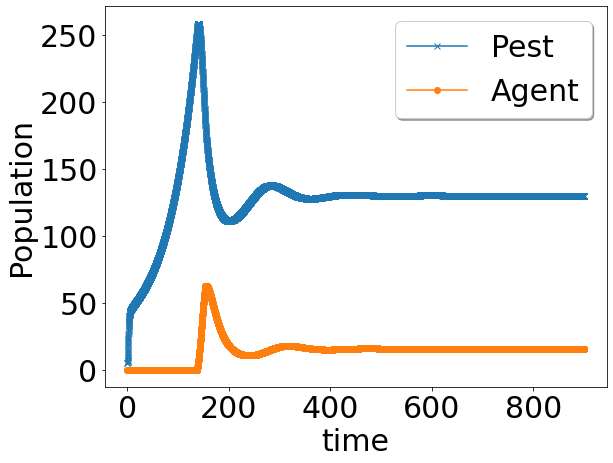

In [11]:
plt.figure(figsize=(9, 7))

plt.plot(time_list, E+L+LBt+A, '-x', label='Pest')
plt.plot(time_list, P, '-o', label='Agent')

plt.xlabel('time')
plt.ylabel('Population')

plt.legend(shadow=True)

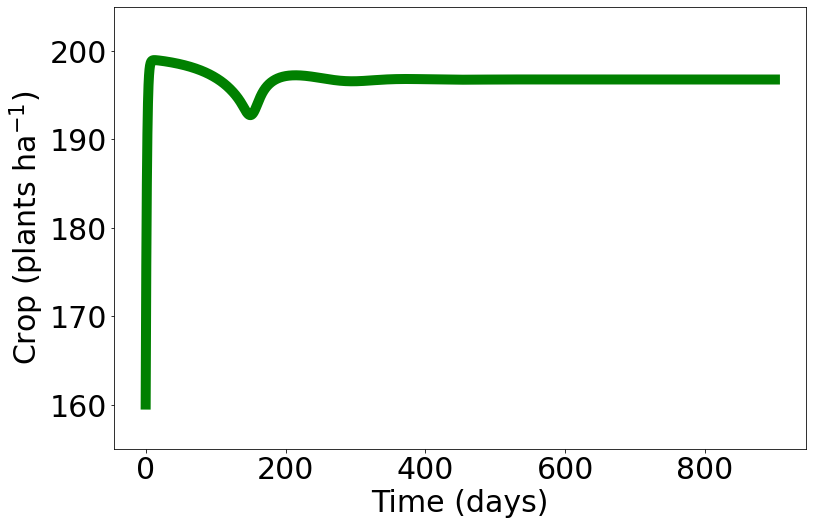

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(time_list, C+CBt, linestyle="-", linewidth=10, color="g") #label="Resource",

plt.xlabel("Time (days)")
plt.ylabel("Crop (plants $\mathregular{ha^{-1}}$)")
plt.rcParams.update({'font.size': 30})

plt.ylim([155, 205])

plt.savefig('img/structured_parasitism_resource.png', format='png')
plt.tight_layout()
plt.show()

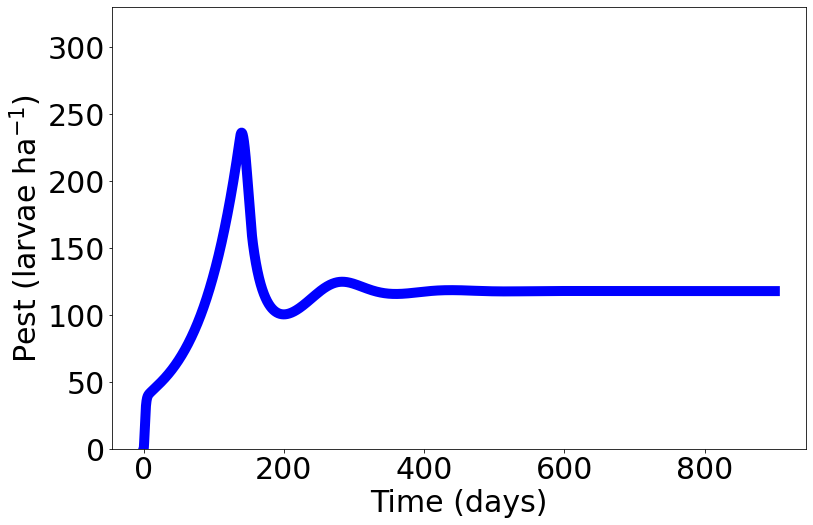

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(time_list, L+LBt, linestyle="-", linewidth=10, markersize=12,color="b") #, label="Pest"

plt.xlabel("Time (days)")
plt.ylabel("Pest (larvae $\mathregular{ha^{-1}}$)")
plt.rcParams.update({'font.size': 30})

plt.ylim([0, 330])

plt.savefig('img/structured_parasitism_pest.png', format='png', bbox_inches = 'tight')
plt.tight_layout()
plt.show()

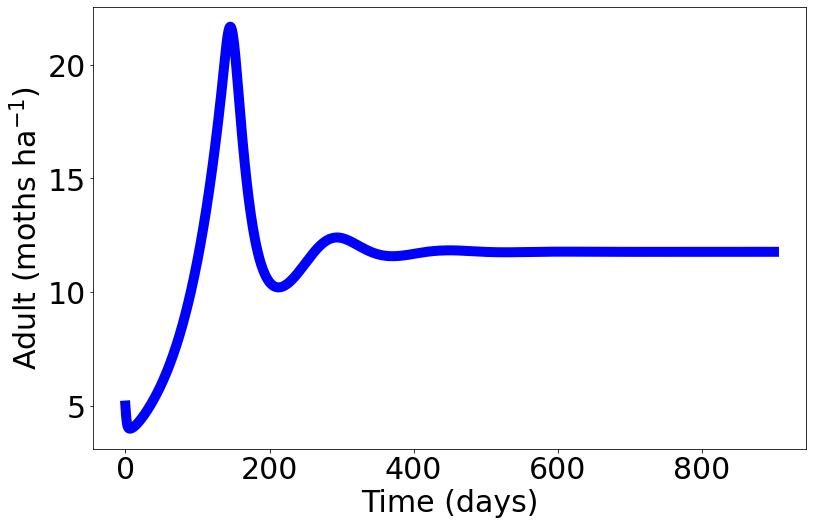

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(time_list, A, linestyle="-", linewidth=10, markersize=12,color="b") #, label="Pest"

plt.xlabel("Time (days)")
plt.ylabel("Adult (moths $\mathregular{ha^{-1}}$)")
plt.rcParams.update({'font.size': 30})

#plt.ylim([0, 1])

#plt.savefig('img/structured_parasitism_pest.png', format='png', bbox_inches = 'tight')
plt.tight_layout()
plt.show()

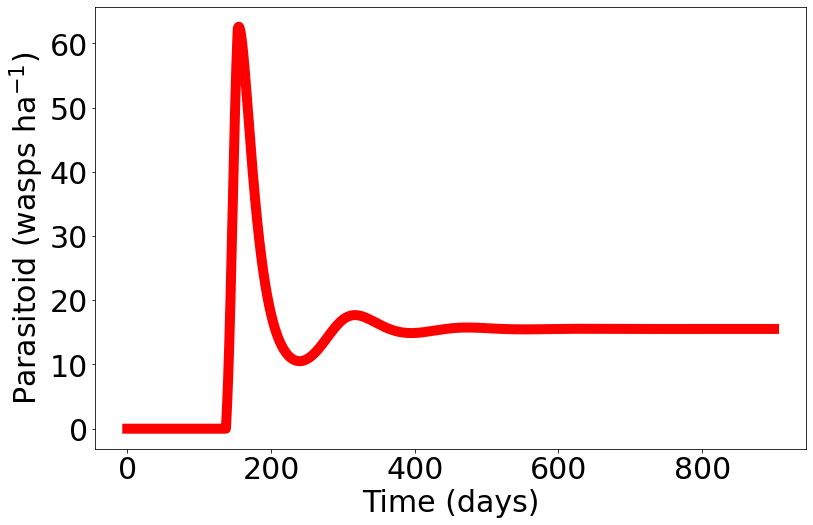

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(time_list, P, linestyle="-", linewidth=10, markersize=12,color="r") #, label="Control Agent"

plt.xlabel("Time (days)")
plt.ylabel("Parasitoid (wasps $\mathregular{ha^{-1}}$)")
plt.rcParams.update({'font.size': 30})

#plt.ylim([0, 1])

plt.savefig('img/structured_parasitism_agent.png', format='png', bbox_inches = 'tight')
plt.tight_layout()
plt.show()

## Sensitivity Analyses

### Pest population

In [16]:
mean_values_params = [
    r,
    K,
    aL,
    hL,
    KBt,
    f,
    nE,
    aP,
    alpha,
    cL,
    qL,
    nL,
    mBt,
    mA,
    mP,
]
factors_names = [
    r"$r$",
    r"$K$",
    r"$\mathregular{a_L}$",
    r"$\mathregular{h_L}$",
    r"$\mathregular{K_{Bt}}$",
    r"$f$",
    r"$\mathregular{n_E}$",
    r"$\mathregular{a_P}$",
    r"$\mathregular{\alpha}$",
    r"$\mathregular{c_L}$",
    r"$\mathregular{q_L}$",
    r"$\mathregular{n_L}$",
    r"$\mathregular{m_{Bt}}$",
    r"$\mathregular{m_A}$",
    r"$\mathregular{m_P}$",
]
params_perturbations = 0.1
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 100
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=True, seed=seed)

In [17]:
t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_list_points = time_list_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_list_points])

for realization_index, parameterL_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_structured_parasitism = structured_parasitism_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_list_range, 
        *parameterL_realization
    )
    C_realization,CBt_realization,E_realization,EBt_realization,L_realization,LBt_realization,M_realization,P_realization = realization_ODE_structured_parasitism.y
    
    qoi_sensitivity_outputs[realization_index, :] = (C_realization + CBt_realization)

  0%|          | 0/64 [00:00<?, ?it/s]<ipython-input-6-855860f0a649>:35: RuntimeWarning: invalid value encountered in double_scalars
  E_prime=(K/(K+KBt))*f*A-nE*E-aP*(E**alpha)*P
<ipython-input-6-855860f0a649>:41: RuntimeWarning: invalid value encountered in double_scalars
  P_prime=aP*(E**alpha+EBt**alpha)*P-mP*P+RP
  2%|▏         | 1/64 [00:00<00:14,  4.20it/s]<ipython-input-6-855860f0a649>:36: RuntimeWarning: invalid value encountered in double_scalars
  EBt_prime=(KBt/(K+KBt))*f*A-nE*EBt-aP*(EBt**alpha)*P
100%|██████████| 64/64 [00:09<00:00,  7.05it/s]


In [18]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_Si['time_list'] = time_list_range
df_sigmai['time_list'] = time_list_range
for time_list_point in tqdm(range(num_of_time_list_points)):
#    try:
    Si = ee_analyze(
        problem_info, 
        parameter_values, 
        qoi_sensitivity_outputs[:, time_list_point], 
        num_levels=grid_level, 
        seed=seed
    )
    # Some parameters combinations may result in simulation failure.
    # This if skip such cases, since they do not have associated sensitivity indicies
    if np.isnan(Si["mu"][-1]):
        continue
        
    Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
    sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
    for idx, param_name in enumerate(problem_info['names']):
        df_Si.loc[time_list_point, param_name] = Si['mu_star_normalized'][idx]
        df_sigmai.loc[time_list_point, param_name] = sigmai_normalized[idx]
#    except:
#        continue

df_Si.dropna(inplace=True)  # remove values that calculation was not possible
df_Si.sort_values(by='time_list', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='time_list', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_time_lists = df_Si.time_list.values
df_Si

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-18-d947ffda287e>:22: RuntimeWarning: invalid value encountered in true_divide
  sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
100%|██████████| 100/100 [00:00<00:00, 190.14it/s]


,time_list,$r$,$K$,$\mathregular{a_L}$,$\mathregular{h_L}$,$\mathregular{K_{Bt}}$,$f$,$\mathregular{n_E}$,$\mathregular{a_P}$,$\mathregular{\alpha}$,$\mathregular{c_L}$,$\mathregular{q_L}$,$\mathregular{n_L}$,$\mathregular{m_{Bt}}$,$\mathregular{m_A}$,$\mathregular{m_P}$
0,9.090909,0.00772553,0.0484116,0.004676,0.00638266,0.921823,0.0015201,0.00108141,0,0,0.0018811,0.000687307,0.00222935,9.36879e-05,0.00348797,0
1,18.181818,0.00562064,0.0471829,0.00484139,0.00865453,0.905567,0.00366286,0.00304394,0,0,0.0048609,0.00252851,0.00614668,0.000280118,0.00761075,0
2,27.272727,0.00620275,0.0455892,0.00526399,0.0113905,0.88286,0.00604561,0.00516237,0,0,0.00868587,0.0049625,0.0108427,0.00049257,0.0125018,0
3,36.363636,0.0070587,0.0436834,0.00590282,0.0145738,0.854791,0.00869319,0.00746802,0,0,0.0137876,0.00813981,0.0166404,0.000745052,0.0185167,0
4,45.454545,0.00827702,0.041341,0.00684412,0.0182434,0.81945,0.0116153,0.00998115,0,0,0.0208433,0.0122238,0.0240012,0.00105793,0.0261215,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,863.636364,0.00427846,0.0292799,0.0324057,0.106303,0.545984,0.0579786,0.0479498,0.0612575,0.0153558,0.00578984,0.0116407,0.0235307,0.00270054,0.0403476,0.015198
95,872.727273,0.00427724,0.0293077,0.0324452,0.106264,0.546841,0.0576434,0.0481759,0.0596386,0.0151804,0.00580517,0.0115369,0.0236582,0.00278398,0.0408873,0.0155547
96,881.818182,0.00426544,0.0292519,0.0323945,0.105934,0.546067,0.0575558,0.0482357,0.0594346,0.0149461,0.00580272,0.0122853,0.0238352,0.00286142,0.0413372,0.0157931
97,890.909091,0.00425424,0.0291905,0.0323383,0.105593,0.545103,0.0574399,0.0482548,0.0596305,0.0147154,0.00579739,0.0129486,0.0240992,0.00293984,0.0417377,0.0159575


In [19]:
df_sigmai

,time_list,$r$,$K$,$\mathregular{a_L}$,$\mathregular{h_L}$,$\mathregular{K_{Bt}}$,$f$,$\mathregular{n_E}$,$\mathregular{a_P}$,$\mathregular{\alpha}$,$\mathregular{c_L}$,$\mathregular{q_L}$,$\mathregular{n_L}$,$\mathregular{m_{Bt}}$,$\mathregular{m_A}$,$\mathregular{m_P}$
0,9.090909,0.200675,0.00498241,0.103386,0.14405,0.187892,0.0363638,0.0282533,0,0,0.0711381,0.0286615,0.0810283,0.00330396,0.110266,0
1,18.181818,0.076883,0.00688746,0.100978,0.151871,0.00540693,0.0545517,0.0583564,0,0,0.128951,0.0616009,0.16602,0.00681098,0.181683,0
2,27.272727,0.0683107,0.0079388,0.0785078,0.125492,0.00638985,0.0525157,0.0584893,0,0,0.145046,0.0686848,0.187314,0.00748908,0.193822,0
3,36.363636,0.0613927,0.00837555,0.0662143,0.107937,0.00633006,0.049112,0.0551626,0,0,0.159709,0.0729939,0.201333,0.00787009,0.203569,0
4,45.454545,0.0571807,0.00833073,0.0591583,0.0932913,0.00614654,0.0449371,0.0502364,0,0,0.174577,0.0754804,0.211163,0.00814496,0.211354,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,863.636364,0.00753278,0.00102983,0.107054,0.212397,0.00467894,0.157802,0.177286,0.175327,0.0229395,0.00721891,0.022947,0.029619,0.00965898,0.0372614,0.0272483
95,872.727273,0.00750792,0.0010369,0.106668,0.211211,0.0053979,0.157613,0.177019,0.176895,0.0227328,0.00720021,0.0216061,0.0301329,0.00992024,0.037867,0.0271922
96,881.818182,0.00748623,0.00104873,0.106334,0.21013,0.00570142,0.1575,0.176798,0.17847,0.0225638,0.00718366,0.0205768,0.0306513,0.0101907,0.0381874,0.0271792
97,890.909091,0.00747086,0.00106377,0.106088,0.20924,0.00563531,0.157498,0.176684,0.179892,0.0224525,0.00717158,0.0199308,0.0310678,0.0104742,0.0381399,0.027191


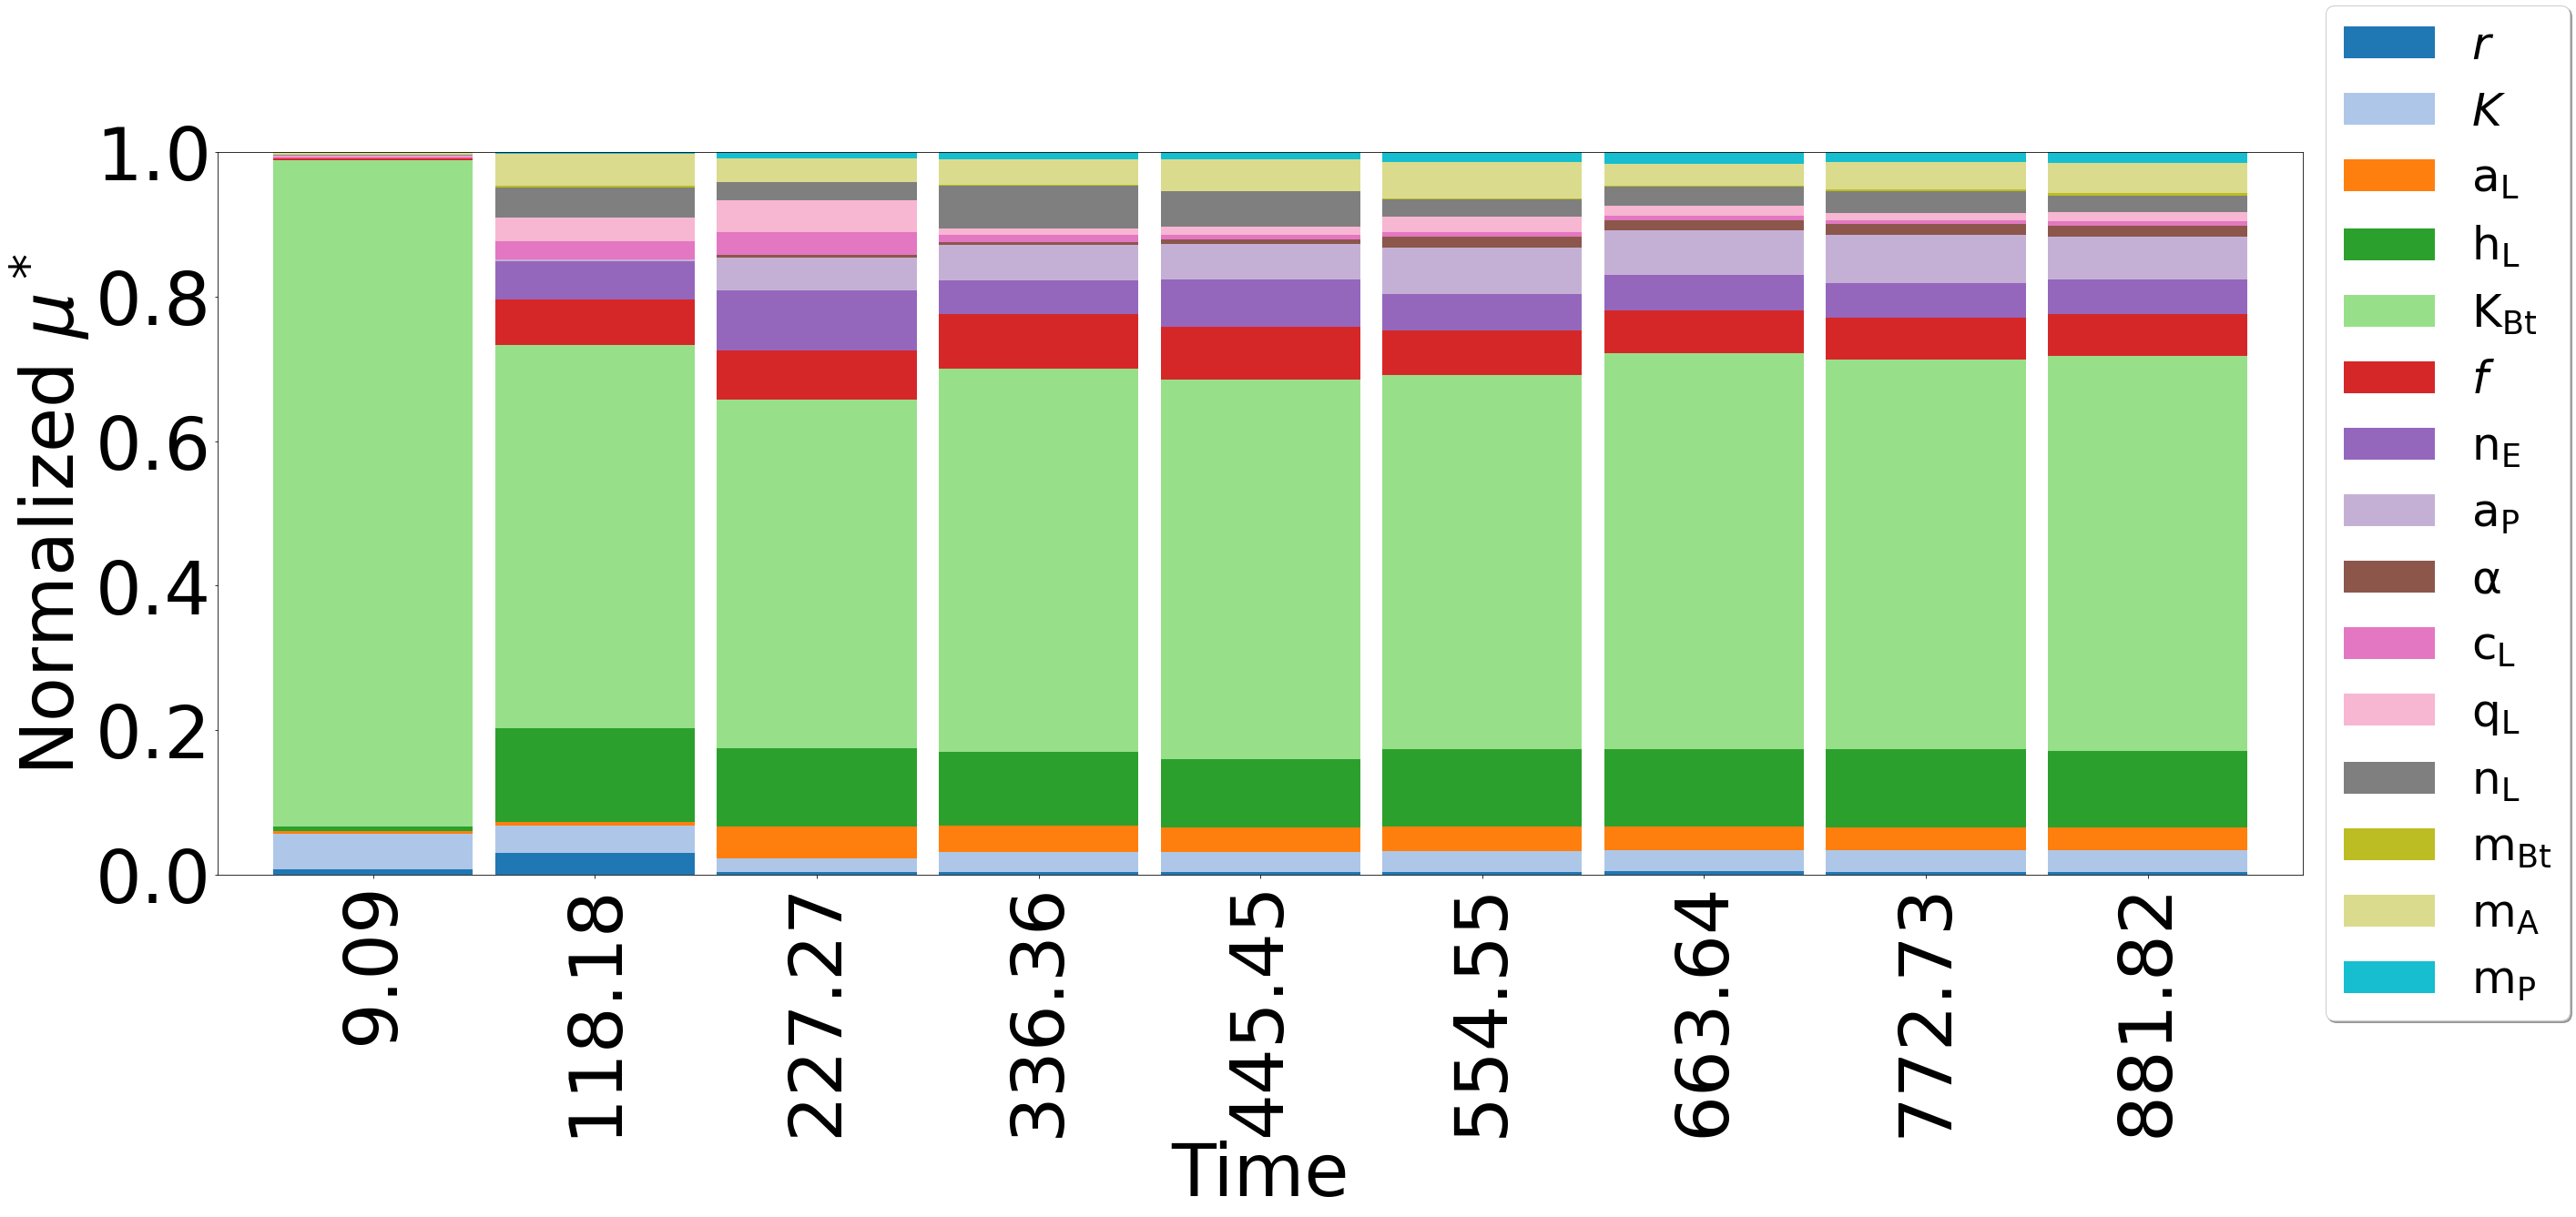

In [20]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 12
valid_time_lists_to_plot_mu = valid_time_lists[::step_to_plot]

#colors = sns.color_palette("coolwarm",16)
colors =  plt.cm.tab20( (4./3*np.arange(20*3/4)).astype(int) )
ax.set_prop_cycle('color', colors)

df_Si[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax, color=colors)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_mu[x]:.2f}")
plt.xlabel("Time", fontsize = 80)
plt.ylabel(r"Normalized $\mu^*$", fontsize = 80)

plt.xticks(fontsize=80)
plt.yticks(fontsize=80)

plt.ylim([0, 1])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fancybox=True, shadow=True, fontsize=50)

plt.tight_layout()
plt.savefig("img/SA_structured_parasitism_mu.png", format='png', bbox_inches = 'tight', dpi=50)
plt.show()

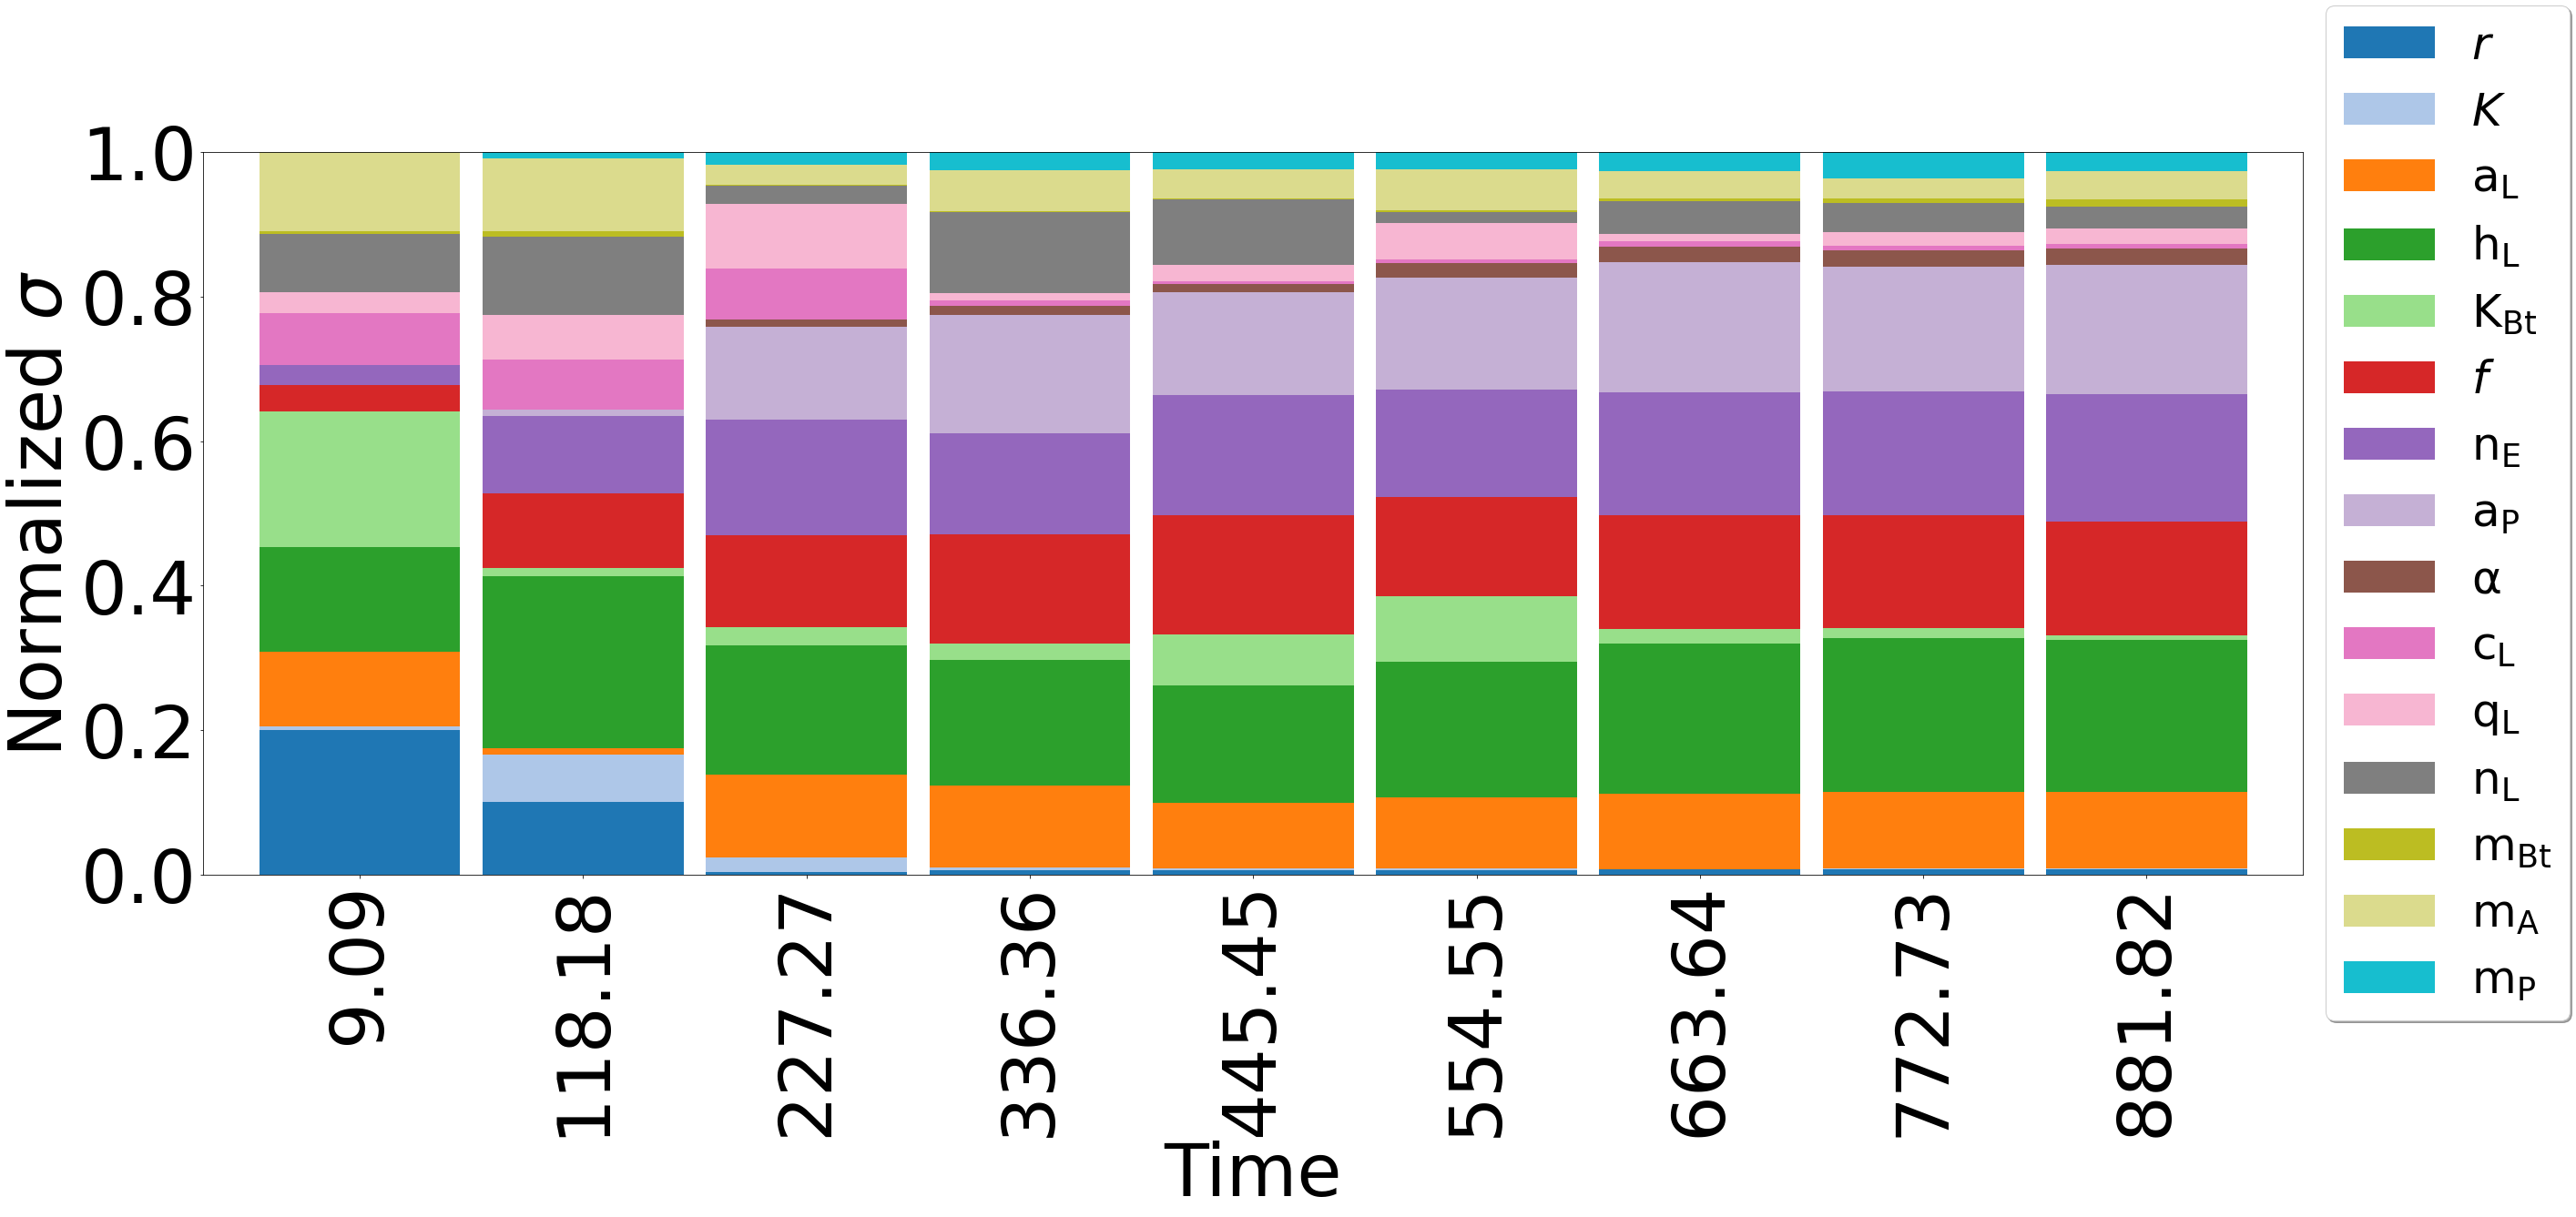

In [21]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 12
valid_time_lists_to_plot_sigma = valid_time_lists[::step_to_plot]

#colors = sns.color_palette("coolwarm",16)
colors =  plt.cm.tab20( (4./3*np.arange(20*3/4)).astype(int) )
ax.set_prop_cycle('color', colors)

df_sigmai[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax, color=colors)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_sigma[x]:.2f}")
plt.xlabel("Time", fontsize = 80)
plt.ylabel(r"Normalized $\sigma$", fontsize = 80)

plt.xticks(fontsize=80)
plt.yticks(fontsize=80)

plt.ylim([0, 1])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fancybox=True, shadow=True, fontsize=50)

plt.tight_layout()
plt.savefig("img/SA_structured_parasitism_sigma.png", format='png', bbox_inches = 'tight', dpi=50)
plt.show()

# Continuation diagram

In [22]:
plt.rcParams.update({'font.size': 8})

tmax = 5000
step = tmax*10
time_list = np.linspace(0, tmax, step)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['lines.linewidth'] = MEDIUM_SIZE
plt.rcParams.update({'font.size': MEDIUM_SIZE})

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [23]:
def structured_parasitism_model(
    t,
    X,
    r=r,
    K=K,
    aL=aL,
    hL=hL,
    KBt=KBt,
    f=f,
    nE=nE,
    aP=aP,
    alpha=alpha,
    cL=cL,
    qL=qL,
    nL=nL,
    mBt=mBt,
    mA=mA,
    mP=mP,
    RP=RP,
    RP_function=inoculative_function,
    sig=sig,
    bound=bound,
):
    C,CBt,E,EBt,L,LBt,A,P = X
#    C: crop
#    CBt: genetically modified Bt crop
#    E: egg pest
#    EBt: egg pest in CBt
#    L: larvae pest in C
#    LBt: larvae pest in CBt
#    A: adult moth pest
#    P: parasitoid of egg (biocontrol agent)
    C_prime=r*C*(1-C/K)-aL*C*A/(1+hL*C)
    CBt_prime=r*CBt*(1-CBt/KBt)-aL*CBt*A/(1+hL*CBt)
    E_prime=(K/(K+KBt))*f*A-nE*E-aP*(E**alpha)*P
    EBt_prime=(KBt/(K+KBt))*f*A-nE*EBt-aP*(EBt**alpha)*P
    L_prime=cL*E*C*A/(1+hL*C)-qL*L**2-nL*L
    LBt_prime=cL*EBt*CBt*A/(1+hL*CBt)-qL*LBt**2-mBt*LBt-nL*LBt
    A_prime=nL*(L+LBt)-mA*A
    RP=RP_function(t,sig,A,bound)
    P_prime=aP*(E**alpha+EBt**alpha)*P-mP*P+RP
    return np.nan_to_num(C_prime),np.nan_to_num(CBt_prime),np.nan_to_num(E_prime),np.nan_to_num(EBt_prime),np.nan_to_num(L_prime),np.nan_to_num(LBt_prime),np.nan_to_num(A_prime),np.nan_to_num(P_prime)

def structured_parasitism_ode_solver(
    y0,
    t_span,
    t_eval,
    r=r,
    K=K,
    aL=aL,
    hL=hL,
    KBt=KBt,
    f=f,
    nE=nE,
    aP=aP,
    alpha=alpha,
    cL=cL,
    qL=qL,
    nL=nL,
    mBt=mBt,
    mA=mA,
    mP=mP,
    RP=RP,
    RP_function=inoculative_function,
    sig=sig,
    bound=bound,
):
    solution_ODE_structured_parasitism = solve_ivp(
        fun=structured_parasitism_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r,K,aL,hL,KBt,f,nE,aP,alpha,cL,qL,nL,mBt,mA,mP),
        method=method,
    )
    return np.nan_to_num(solution_ODE_structured_parasitism)

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0

Running continuation:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-23-023d8925fa6e>:35: RuntimeWarning: invalid value encountered in double_scalars
  E_prime=(K/(K+KBt))*f*A-nE*E-aP*(E**alpha)*P
<ipython-input-23-023d8925fa6e>:41: RuntimeWarning: invalid value encountered in double_scalars
  P_prime=aP*(E**alpha+EBt**alpha)*P-mP*P+RP
Running continuation:   1%|          | 1/100 [00:00<00:15,  6.25it/s]<ipython-input-23-023d8925fa6e>:36: RuntimeWarning: invalid value encountered in double_scalars
  EBt_prime=(KBt/(K+KBt))*f*A-nE*EBt-aP*(EBt**alpha)*P
Plotting results: 100%|██████████| 8/8 [00:00<00:00, 63.20it/s]
<ipython-input-24-c14308fbd310>:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


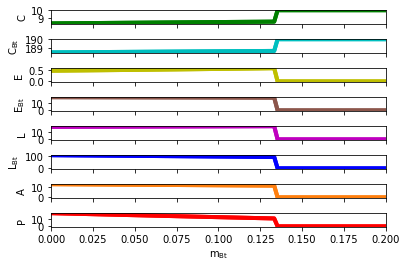

In [24]:
def run_continuation_analysis(
    ode_solver_wrapper,
    continuation_variable_name,
    parameter_span,
    parameter_num_of_points,
    fixed_parameters_dict,
    initial_conditions,
    output_variable_name_list,
    num_of_last_outcomes,
):
    if type(continuation_variable_name) != str:
        raise ValueError("Input continuation_variable_name must be of str type.")

    if type(parameter_num_of_points) != int:
        raise ValueError("Input parameter_num_of_points must be of integer type.")

    parameter_span_type = type(parameter_span)
    if parameter_span_type != tuple and parameter_span_type != list:
        raise ValueError("Input parameter_span must be a list or tuple of values.")
    else:
        if len(parameter_span) != 2:
            raise ValueError("Input parameter_span must be a list or tuple with two values.")

    if len(initial_conditions) != len(output_variable_name_list):
        raise ValueError(
            "The number of output variables from ODE model must be equal to number of initial conditions."
        )

    parameter_values = np.linspace(parameter_span[0], parameter_span[1], parameter_num_of_points)
    continuation_parameter_values_dict = {continuation_variable_name: parameter_values}
    time_values = time_list

    # Creating dictionary to record continuation realizations
    output_variables_dict = dict()
    for output_variable_name in output_variable_name_list:
        output_variables_dict[output_variable_name] = list()

    # Running continuation evaluations
    parameter_progress_bar = tqdm(parameter_values)
    for parameter_value in parameter_progress_bar:
        parameter_progress_bar.set_description("Running continuation")
        parameters = fixed_parameters
        parameters[continuation_variable_name] = parameter_value
        ode_solver_output = ode_solver_wrapper(initial_conditions, (t0, tf + days_to_forecast), time_values, **parameters)
        t_output, y_output = ode_solver_output.t, ode_solver_output.y
        y_last_outputs = y_output[:, -num_of_last_outcomes:]
        output_index = 0
        for output_variable_name in output_variable_name_list:
            output_variable_last_results = y_last_outputs[output_index]
            output_variables_dict[output_variable_name].append(
                [output_variable_last_results.min(), output_variable_last_results.max()]
            )
            output_index += 1

    return continuation_parameter_values_dict, output_variables_dict

fixed_parameters = {
    "r": r,
    "K": K,
    "aL": aL,
    "hL": hL,
    "KBt": KBt,
    "f": f,
    "nE": nE,
    "aP": aP,
    "alpha": alpha,
    "cL": cL,
    "qL": qL,
    "nL": nL,
#    "mBt": mBt,
    "mA": mA,
    "mP": mP,
}


mBt_min = 0.0
mBt_max = 0.2
mBt_points = np.linspace(mBt_min, mBt_max, num_of_points)
parameter_to_continuation = {"mBt": mBt_points}

mBt_values, y_last_results = run_continuation_analysis(
    ode_solver_wrapper=structured_parasitism_ode_solver,
    continuation_variable_name="mBt",
    parameter_span=(mBt_min, mBt_max),
    parameter_num_of_points=num_of_points,
    fixed_parameters_dict=fixed_parameters,
    initial_conditions=y0,
    output_variable_name_list=["C","$\mathregular{C_{Bt}}$","E","$\mathregular{E_{Bt}}$","L","$\mathregular{L_{Bt}}$","A","P"],
    num_of_last_outcomes=100,
)

colors_list = ["g","c","y","tab:brown","m","b","tab:orange","r"]
results_progress_bar = tqdm(y_last_results)
num_of_state_variables = len(y_last_results)
fig, axs = plt.subplots(num_of_state_variables, sharex=True, gridspec_kw={"hspace": 1})
index = 0
for variable_name in results_progress_bar:
    results_progress_bar.set_description("Plotting results")
    variable_result = np.array(y_last_results[variable_name])
    variable_min_values = variable_result[:, 0].astype(np.int)
    variable_max_values = variable_result[:, 1].astype(np.int)

    color = colors_list[index]
    axs[index].plot(
        mBt_values["mBt"], variable_result, color=color, alpha=1, linewidth=4
    )

    index += 1

for ax, variable_name in zip(axs.flat, y_last_results):
    ax.set(xlabel=r"$\mathregular{m_{Bt}}$", ylabel=f"{variable_name}", xlim=(mBt_min, mBt_max))
    ax.plot(linewidth=15, markersize=20)
    ax.label_outer()

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['lines.linewidth'] = MEDIUM_SIZE
plt.rcParams.update({'font.size': MEDIUM_SIZE})

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

plt.tight_layout()
plt.savefig("img/continuation_mBt.png", format='png', bbox_inches = "tight", dpi=300)

Running continuation:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-23-023d8925fa6e>:35: RuntimeWarning: invalid value encountered in double_scalars
  E_prime=(K/(K+KBt))*f*A-nE*E-aP*(E**alpha)*P
<ipython-input-23-023d8925fa6e>:36: RuntimeWarning: invalid value encountered in double_scalars
  EBt_prime=(KBt/(K+KBt))*f*A-nE*EBt-aP*(EBt**alpha)*P
<ipython-input-23-023d8925fa6e>:41: RuntimeWarning: invalid value encountered in double_scalars
  P_prime=aP*(E**alpha+EBt**alpha)*P-mP*P+RP
Plotting results: 100%|██████████| 8/8 [00:00<00:00, 62.93it/s]
<ipython-input-25-685a1d08355e>:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


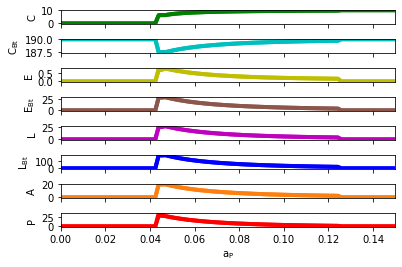

In [25]:
def run_continuation_analysis(
    ode_solver_wrapper,
    continuation_variable_name,
    parameter_span,
    parameter_num_of_points,
    fixed_parameters_dict,
    initial_conditions,
    output_variable_name_list,
    num_of_last_outcomes,
):
    if type(continuation_variable_name) != str:
        raise ValueError("Input continuation_variable_name must be of str type.")

    if type(parameter_num_of_points) != int:
        raise ValueError("Input parameter_num_of_points must be of integer type.")

    parameter_span_type = type(parameter_span)
    if parameter_span_type != tuple and parameter_span_type != list:
        raise ValueError("Input parameter_span must be a list or tuple of values.")
    else:
        if len(parameter_span) != 2:
            raise ValueError("Input parameter_span must be a list or tuple with two values.")

    if len(initial_conditions) != len(output_variable_name_list):
        raise ValueError(
            "The number of output variables from ODE model must be equal to number of initial conditions."
        )

    parameter_values = np.linspace(parameter_span[0], parameter_span[1], parameter_num_of_points)
    continuation_parameter_values_dict = {continuation_variable_name: parameter_values}
    time_values = time_list

    # Creating dictionary to record continuation realizations
    output_variables_dict = dict()
    for output_variable_name in output_variable_name_list:
        output_variables_dict[output_variable_name] = list()

    # Running continuation evaluations
    parameter_progress_bar = tqdm(parameter_values)
    for parameter_value in parameter_progress_bar:
        parameter_progress_bar.set_description("Running continuation")
        parameters = fixed_parameters
        parameters[continuation_variable_name] = parameter_value
        ode_solver_output = ode_solver_wrapper(initial_conditions, (t0, tf + days_to_forecast), time_values, **parameters)
        t_output, y_output = ode_solver_output.t, ode_solver_output.y
        y_last_outputs = y_output[:, -num_of_last_outcomes:]
        output_index = 0
        for output_variable_name in output_variable_name_list:
            output_variable_last_results = y_last_outputs[output_index]
            output_variables_dict[output_variable_name].append(
                [output_variable_last_results.min(), output_variable_last_results.max()]
            )
            output_index += 1

    return continuation_parameter_values_dict, output_variables_dict

fixed_parameters = {
    "r": r,
    "K": K,
    "aL": aL,
    "hL": hL,
    "KBt": KBt,
    "f": f,
    "nE": nE,
#    "aP": aP,
    "alpha": alpha,
    "cL": cL,
    "qL": qL,
    "nL": nL,
    "mBt": mBt,
    "mA": mA,
    "mP": mP,
}


aP_min = 0.0
aP_max = 0.15
aP_points = np.linspace(aP_min, aP_max, num_of_points)
parameter_to_continuation = {"aP": aP_points}

aP_values, y_last_results = run_continuation_analysis(
    ode_solver_wrapper=structured_parasitism_ode_solver,
    continuation_variable_name="aP",
    parameter_span=(aP_min, aP_max),
    parameter_num_of_points=num_of_points,
    fixed_parameters_dict=fixed_parameters,
    initial_conditions=y0,
    output_variable_name_list=["C","$\mathregular{C_{Bt}}$","E","$\mathregular{E_{Bt}}$","L","$\mathregular{L_{Bt}}$","A","P"],
    num_of_last_outcomes=100,
)

colors_list = ["g","c","y","tab:brown","m","b","tab:orange","r"]
results_progress_bar = tqdm(y_last_results)
num_of_state_variables = len(y_last_results)
fig, axs = plt.subplots(num_of_state_variables, sharex=True, gridspec_kw={"hspace": 1})
index = 0
for variable_name in results_progress_bar:
    results_progress_bar.set_description("Plotting results")
    variable_result = np.array(y_last_results[variable_name])
    variable_min_values = variable_result[:, 0].astype(np.int)
    variable_max_values = variable_result[:, 1].astype(np.int)

    color = colors_list[index]
    axs[index].plot(
        aP_values["aP"], variable_result, color=color, alpha=1, linewidth=4
    )

    index += 1

for ax, variable_name in zip(axs.flat, y_last_results):
    ax.set(xlabel=r"$\mathregular{a_P}$", ylabel=f"{variable_name}", xlim=(aP_min, aP_max))
    ax.plot(linewidth=15, markersize=20)
    ax.label_outer()

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['lines.linewidth'] = MEDIUM_SIZE
plt.rcParams.update({'font.size': MEDIUM_SIZE})

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

#fig.subplots_adjust(hspace=0.3)

plt.tight_layout()
plt.savefig("img/continuation_aP.png", format='png', bbox_inches = "tight", dpi=300)

Running continuation:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-23-023d8925fa6e>:35: RuntimeWarning: invalid value encountered in double_scalars
  E_prime=(K/(K+KBt))*f*A-nE*E-aP*(E**alpha)*P
<ipython-input-23-023d8925fa6e>:36: RuntimeWarning: invalid value encountered in double_scalars
  EBt_prime=(KBt/(K+KBt))*f*A-nE*EBt-aP*(EBt**alpha)*P
<ipython-input-23-023d8925fa6e>:41: RuntimeWarning: invalid value encountered in double_scalars
  P_prime=aP*(E**alpha+EBt**alpha)*P-mP*P+RP
Plotting results: 100%|██████████| 8/8 [00:00<00:00, 62.72it/s]
<ipython-input-26-84c2e1b4ec0f>:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


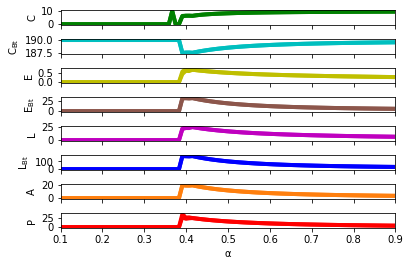

In [26]:
def run_continuation_analysis(
    ode_solver_wrapper,
    continuation_variable_name,
    parameter_span,
    parameter_num_of_points,
    fixed_parameters_dict,
    initial_conditions,
    output_variable_name_list,
    num_of_last_outcomes,
):
    if type(continuation_variable_name) != str:
        raise ValueError("Input continuation_variable_name must be of str type.")

    if type(parameter_num_of_points) != int:
        raise ValueError("Input parameter_num_of_points must be of integer type.")

    parameter_span_type = type(parameter_span)
    if parameter_span_type != tuple and parameter_span_type != list:
        raise ValueError("Input parameter_span must be a list or tuple of values.")
    else:
        if len(parameter_span) != 2:
            raise ValueError("Input parameter_span must be a list or tuple with two values.")

    if len(initial_conditions) != len(output_variable_name_list):
        raise ValueError(
            "The number of output variables from ODE model must be equal to number of initial conditions."
        )

    parameter_values = np.linspace(parameter_span[0], parameter_span[1], parameter_num_of_points)
    continuation_parameter_values_dict = {continuation_variable_name: parameter_values}
    time_values = time_list

    # Creating dictionary to record continuation realizations
    output_variables_dict = dict()
    for output_variable_name in output_variable_name_list:
        output_variables_dict[output_variable_name] = list()

    # Running continuation evaluations
    parameter_progress_bar = tqdm(parameter_values)
    for parameter_value in parameter_progress_bar:
        parameter_progress_bar.set_description("Running continuation")
        parameters = fixed_parameters
        parameters[continuation_variable_name] = parameter_value
        ode_solver_output = ode_solver_wrapper(initial_conditions, (t0, tf + days_to_forecast), time_values, **parameters)
        t_output, y_output = ode_solver_output.t, ode_solver_output.y
        y_last_outputs = y_output[:, -num_of_last_outcomes:]
        output_index = 0
        for output_variable_name in output_variable_name_list:
            output_variable_last_results = y_last_outputs[output_index]
            output_variables_dict[output_variable_name].append(
                [output_variable_last_results.min(), output_variable_last_results.max()]
            )
            output_index += 1

    return continuation_parameter_values_dict, output_variables_dict

fixed_parameters = {
    "r": r,
    "K": K,
    "aL": aL,
    "hL": hL,
    "KBt": KBt,
    "f": f,
    "nE": nE,
    "aP": aP,
#    "alpha": alpha,
    "cL": cL,
    "qL": qL,
    "nL": nL,
    "mBt": mBt,
    "mA": mA,
    "mP": mP,
}


alpha_min = 0.1
alpha_max = 0.9
alpha_points = np.linspace(alpha_min, alpha_max, num_of_points)
parameter_to_continuation = {"alpha": alpha_points}

alpha_values, y_last_results = run_continuation_analysis(
    ode_solver_wrapper=structured_parasitism_ode_solver,
    continuation_variable_name="alpha",
    parameter_span=(alpha_min, alpha_max),
    parameter_num_of_points=num_of_points,
    fixed_parameters_dict=fixed_parameters,
    initial_conditions=y0,
    output_variable_name_list=["C","$\mathregular{C_{Bt}}$","E","$\mathregular{E_{Bt}}$","L","$\mathregular{L_{Bt}}$","A","P"],
    num_of_last_outcomes=100,
)

colors_list = ["g","c","y","tab:brown","m","b","tab:orange","r"]
results_progress_bar = tqdm(y_last_results)
num_of_state_variables = len(y_last_results)
fig, axs = plt.subplots(num_of_state_variables, sharex=True, gridspec_kw={"hspace": 1})
index = 0
for variable_name in results_progress_bar:
    results_progress_bar.set_description("Plotting results")
    variable_result = np.array(y_last_results[variable_name])
    variable_min_values = variable_result[:, 0].astype(np.int)
    variable_max_values = variable_result[:, 1].astype(np.int)

    color = colors_list[index]
    axs[index].plot(
        alpha_values["alpha"], variable_result, color=color, alpha=1, linewidth=4
    )
#    ax.annotate(s=str(variable_name), xy=(.4,.4), fontsize=16)
    index += 1

for ax, variable_name in zip(axs.flat, y_last_results):
    ax.set(xlabel=r"$\mathregular{\alpha}$", ylabel=f"{variable_name}", xlim=(alpha_min, alpha_max))
    ax.plot(linewidth=15, markersize=20)
    ax.label_outer()

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['lines.linewidth'] = MEDIUM_SIZE
plt.rcParams.update({'font.size': MEDIUM_SIZE})

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

plt.tight_layout()
plt.savefig("img/continuation_alpha.png", format='png', bbox_inches = "tight", dpi=300)